---
# <b>1. Create harmonized/standardized PFT table<b>

In [1]:
import pandas as pd
import geopandas as gpd
import uuid
import matplotlib.pyplot as plt
import re
from math import ceil
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## 1.a Concatenate fcover tables

In [21]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
pft_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_standard_pft_fcover.csv'
    df = pd.read_csv(path, index_col=0)
    pft_dfs.append(df)
pft_fcover = pd.concat(pft_dfs)
    
# rename columns for ESS-Dive
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

# adjust column names and index
pft_fcover.columns = [camel_to_snake(col) for col in pft_fcover.columns]
pft_fcover.index.name = 'plot_id'
pft_fcover['unique_id'] = pd.factorize(pft_fcover.index)[0]
pft_fcover = pft_fcover.reset_index()
pft_fcover = pft_fcover.set_index('unique_id')

# export
pft_fcover.to_csv('standardized_pft_fcover.csv')

In [22]:
pft_fcover.head(3)

,plot_id,deciduous_shrub_cover,deciduous_tree_cover,evergreen_shrub_cover,evergreen_tree_cover,forb_cover,graminoid_cover,nonvascular_sum_cover,bryophyte_cover,lichen_cover,litter_cover,other_cover,water_cover,bareground_cover
unique_id,,,,,,,,,,,,,,
0,120712b1,32.45,0.0,20.52,0.0,2.64,19.20,33.09,31.77,1.32,18.54,0.0,0.0,0.00
1,120713a1,0.00,0.0,0.00,0.0,1.96,28.75,37.25,36.60,0.65,77.78,0.0,0.0,11.11
2,120713b1,11.34,0.0,38.01,0.0,0.00,14.66,26.00,17.34,8.66,32.67,0.0,0.0,0.00


## 1.b. Concatenate auxiliary columns

In [23]:
# pft_fcover
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
aux_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_plot_info.csv'
    df = pd.read_csv(path, index_col=0)
    aux_dfs.append(df)
aux = pd.concat(aux_dfs)

# set data types
intcols = ['surveyYear', 'surveyMonth', 'surveyDay', 'bioclimSubzone']
for col in intcols:
    aux[col] = aux[col].astype('Int64')

# adjust column names and index
aux.columns = [camel_to_snake(col) for col in aux.columns]
aux.index.name = 'plot_id'
aux['unique_id'] = pd.factorize(aux.index)[0]
aux = aux.reset_index()
aux = aux.set_index('unique_id')
    
aux.to_csv('standardized_plot_information_temp.csv')

## 1.b Fill in missing aux variables manually
Save as `standardized_plot_information.csv`

## 1.c Load fixed table

In [24]:
aux = pd.read_csv('standardized_plot_information.csv')
aux.columns

Index(['plot_id', 'survey_year', 'survey_month', 'survey_day', 'plot_radius',
       'latitude_y', 'longitude_x', 'georef_source', 'georef_accuracy',
       'coord_epsg', 'data_subsource', 'data_source', 'survey_method',
       'fcover_scale', 'survey_purpose', 'geometry', 'admin_unit',
       'admin_country', 'fire_years', 'bioclim_subzone', 'duplicated_coords',
       'duplicated_date'],
      dtype='object')

In [25]:
aux.groupby('data_subsource').count()['plot_id']

data_subsource
AIM NPR-A Timm Nawrocki                      185
Atqasuk Vera Komarkova                        31
Barrow DOE NGEE Victoria Sloan                48
Barrow IBP Tundra Biome Pat Webber            33
Flux Tower Zona Scott Davidson               140
NGEE-Arctic Amy Breen                         98
Prudhoe ArcSEES road study Donald Walker      29
Prudhoe Bay Airport ArcSEES Donald Walker     27
Shell Onshore Matthew Macander               107
Toolik Field Station NEON                     84
Utqiagvik-Barrow NEON                        196
Name: plot_id, dtype: int64

In [26]:
# Initialize the MinMaxScaler with the desired feature range
scaler = MinMaxScaler(feature_range=(0, 100))

# Fit and transform the data
cover_cols = [col for col in pft_fcover.columns if 'cover' in col]
pft_fcover_scaled = pd.DataFrame(scaler.fit_transform(pft_fcover[cover_cols]), columns=cover_cols)

## 1.d Plot PFT distribution

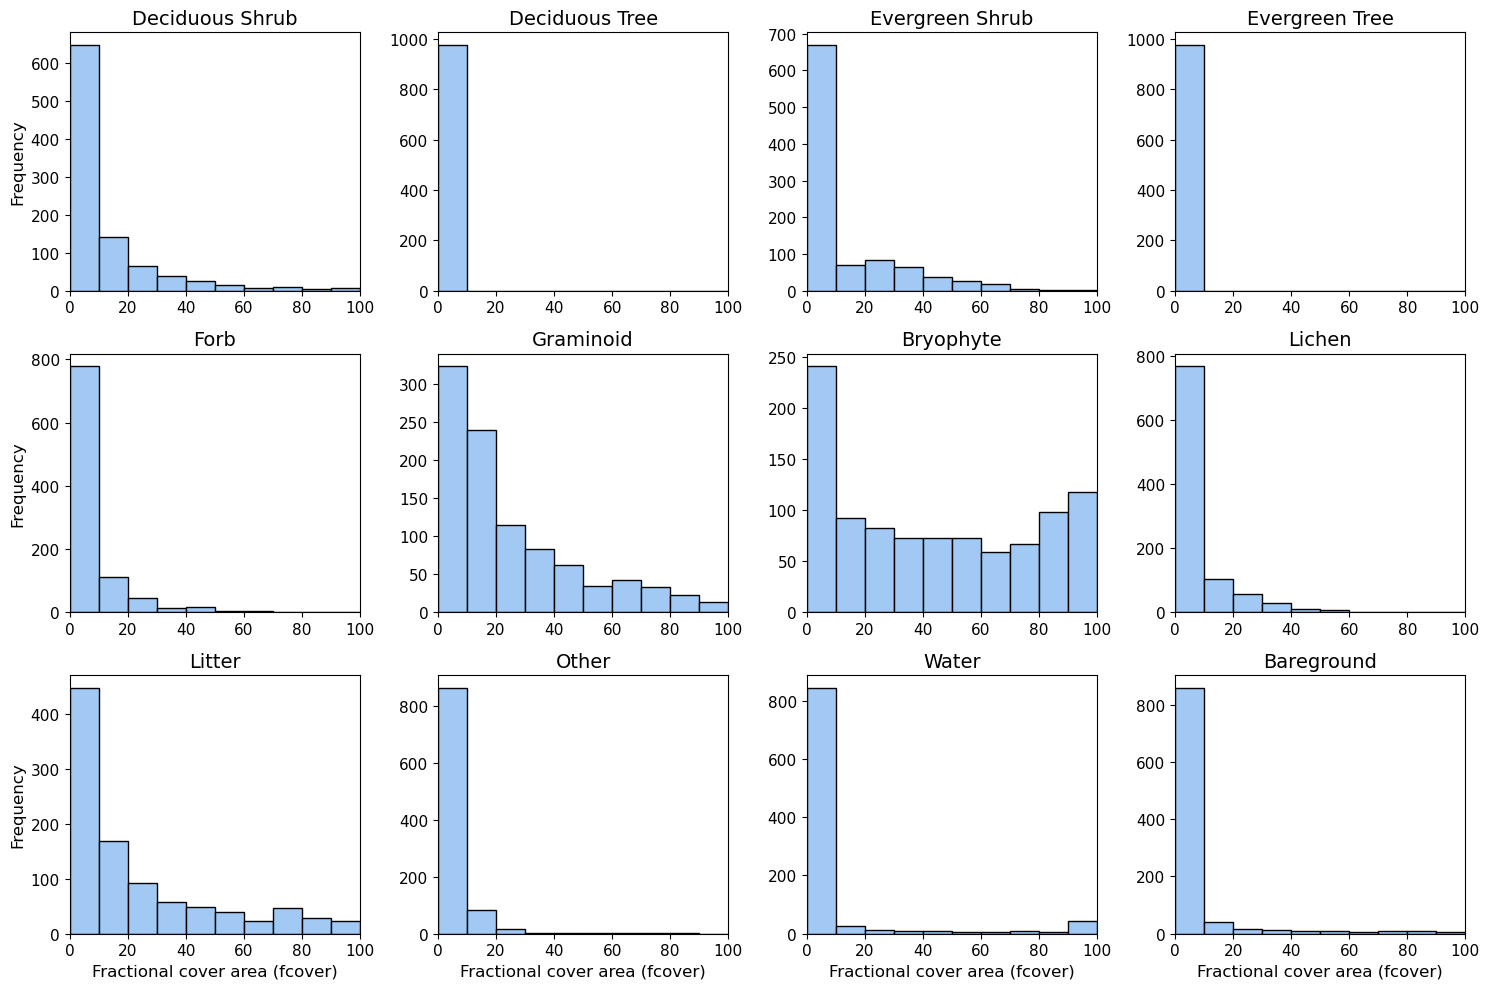

In [33]:
# List of fcover types (assuming columns represent different fcover types)
fcover_types = [col for col in pft_fcover_scaled.columns if 'cover' in col and col not in ['nonvascular_sum_cover']]

# Number of subplots (assuming 10 fcover types)
num_subplots = len(fcover_types)
nrows = 3
ncols = ceil(num_subplots / nrows)

# Determine the common x and y axis ranges
all_values = pd.concat([pft_fcover_scaled[col].dropna() for col in fcover_types])
x_min, x_max = all_values.min(), all_values.max()

# Create a figure and subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), sharex=True)

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Set Seaborn style and color palette
palette = sns.color_palette("pastel")

# Define bin edges
bin_width = 10  # Adjust as needed
# num_bins = int((x_max - x_min) / bin_width)

# Define bin edges
bin_edges = range(int(x_min), int(x_max) + bin_width, bin_width)

# Function to format fcover_type titles
def format_fcover_title(fcover_type):
    # Remove '_cover' suffix and capitalize words
    formatted_title = fcover_type.replace('_cover', '').replace('_', ' ').title()
    return formatted_title

# Plot each fcover type in a separate subplot
for i, fcover_type in enumerate(fcover_types):
    axs[i].hist(pft_fcover[fcover_type], bins=bin_edges, color=palette[0], edgecolor='black', align='mid')
    axs[i].set_title(format_fcover_title(fcover_type), fontsize=14)
    axs[i].set_xlim(x_min, x_max)
    axs[i].tick_params(axis='both', which='major', labelsize=11)
    axs[i].xaxis.set_tick_params(labelbottom=True)
    
    # Set x-axis label only for the bottom row
    if i >= (nrows - 1) * ncols:
        axs[i].set_xlabel('Fractional cover area (fcover)', fontsize=12)
    
    # Set y-axis label only for the far-left column
    if i % ncols == 0:
        axs[i].set_ylabel('Frequency', fontsize=12)
    
# # Set y-axis limits based on the highest bin count across all subplots
# max_y = max(ax.get_ylim()[1] for ax in axs[:num_subplots])
# for ax in axs[:num_subplots]:
#     ax.set_ylim(0, max_y)

# Remove any empty subplots
for j in range(num_subplots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()

---
# 2. Create harmonized/standardized species checklist

In [76]:
# create species name dataframe
sources = ['abr', 'akveg', 'ava', 'neon', 'nga']
species_dfs = []
for source in sources:
    path = f'{source}/output_data/{source}_nonstandard_species_fcover.csv' 
    df = pd.read_csv(path, index_col=0)
    species_dfs.append(df)
species_fcover = pd.concat(species_dfs, axis=0)
species_fcover = species_fcover.reset_index()
print(len(species_habit['datasetSpeciesName'].unique()))
species_fcover.head(3)

2261


,plotName,datasetSpeciesName,standardHabit,percentCover
0,120712b1,Litter,litter,18.54
1,120713a1,Litter,litter,77.78
2,120713b1,Litter,litter,32.67


## 2a. Load dataframe with manually assigned acceptedName

In [82]:
# load species name dataframe with corresponding accepted names
standard_species = pd.read_csv('species_standardization_mapping.csv')
print(len(standard_species['datasetSpeciesName'].unique()))
standard_species.head(3)

2251


,datasetSpeciesName,acceptedName,namingAuthority
0,Juniperus communis,Juniperus communis L.,Adams 2018
1,Dicranum dispersum,Dicranum dispersum Engelm.,Afonina and Breen 2009
2,Thelypteris quelpaertensis,Oreopteris quelpaertensis (Christ) Holub,Almeida et al. 2016


## 2c. Join PFT and name source to datasetSpeciesName/AcceptedName

In [83]:
standard_species_fcover = pd.merge(left=species_fcover, right=standard_species, 
                                      left_on='datasetSpeciesName', right_on='datasetSpeciesName', 
                                      how='left')
species_pft_checklist = standard_species_fcover.drop(columns=['plotName', 'percentCover', 'datasetSpeciesName'])
species_pft_checklist = species_pft_checklist.drop_duplicates('acceptedName')
species_pft_checklist = species_pft_checklist.rename(columns={'standardHabit':'pft',
                                                              'acceptedName':'accepted_name',
                                                              'namingAuthority':'naming_authority'})
species_pft_checklist = species_pft_checklist.reset_index(drop=True)
species_pft_checklist = species_pft_checklist[['accepted_name', 'naming_authority', 'pft']]
species_pft_checklist

,accepted_name,naming_authority,pft
0,NaN,NaN,litter
1,Hylocomium splendens (Hedw.) Schimp.,Flora of North America,bryophyte
2,Carex bigelowii Torr. ex Schwein.,Panarctic Flora Project Checklist,graminoid
3,Alnus alnobetula ssp. fruticosa (Rupr.) Raus.,Greuter and von Raab-Straube 2011,deciduous shrub
4,Vaccinium uliginosum L.,Flora of North America,deciduous shrub
...,...,...,...
1718,Lophocolea minor Nees,Stotler & Crandall-Stotler 2017,bryophyte
1719,Cladonia coniocraea (Flörke) Spreng.,McCune et al. 2018,lichen
1720,Campylopus flexuosus (Hedw.) Brid.,Flora of North America,bryophyte
1721,Oncophorus demetrii (Renauld & Cardot) Hedenäs,Consortium of Bryophyte Herbaria,bryophyte


In [84]:
standard_species_fcover = standard_species_fcover[['plotName', 'acceptedName', 'standardHabit', 'percentCover']]
standard_species_fcover = standard_species_fcover.rename(columns={'plotName':'plot_id',
                                                                  'acceptedName':'accepted_name',
                                                                  'standardHabit':'pft',
                                                                  'percentCover':'fcover'})
standard_species_fcover

,plot_id,accepted_name,pft,fcover
0,120712b1,NaN,litter,18.54
1,120713a1,NaN,litter,77.78
2,120713b1,NaN,litter,32.67
3,120714a1,NaN,litter,15.23
4,120714a2,NaN,litter,84.87
...,...,...,...,...
93323,TL_WNAC7_VgComp,Drepanocladus polygamus (Schimp.) Hedenäs,bryophyte,1.00
93324,TL_WNAC7_VgComp,Blepharostoma trichophyllum (L.) Dumort.,bryophyte,1.00
93325,TL_WNAC7_VgComp,Campylophyllum sommerfeltii (Myr.) Hedenäs,bryophyte,1.00
93326,TL_WNAC7_VgComp,Scorpidium revolvens (Sw.) Hedenäs,bryophyte,1.00


In [86]:
# Group by 'plotName' and 'acceptedName' and sum the 'percentCover' values
standard_species_fcover = standard_species_fcover.groupby(['plot_id', 'accepted_name'], as_index=False)['fcover'].sum()
standard_species_fcover

,plot_id,accepted_name,fcover
0,010A,Abietinella abietina (Hedw.) Fleisch.,0.10
1,010A,Alectoria nigricans (Ach.) Nyl.,0.10
2,010A,Alopecurus borealis Trin.,0.10
3,010A,Bistorta vivipara (L.) Delarbre,0.70
4,010A,Bryum Hedw.,0.10
...,...,...,...
89027,YUK9,Populus balsamifera L.,37.50
89028,YUK9,Rosa acicularis Lindl.,15.00
89029,YUK9,Rubus idaeus L.,0.55
89030,YUK9,Tanacetum bipinnatum (L.) Sch. Bip.,0.55


In [87]:
# Get the unique plot IDs from aux
post2010_plot_ids = aux['plot_id'].unique()

# Filter the dataframe to only include rows where plotName is in valid_plot_ids
post2010_standard_species_fcover = standard_species_fcover[standard_species_fcover['plot_id'].isin(post2010_plot_ids)]
post2010_standard_species_fcover.set_index('plot_id', inplace=True)
post2010_standard_species_fcover

,accepted_name,fcover
plot_id,,
120712b1,Alnus alnobetula ssp. fruticosa (Rupr.) Raus.,10.60
120712b1,Andromeda polifolia L.,0.66
120712b1,Aulacomnium turgidum (Wahlenb.) Schwägr.,3.97
120712b1,Betula nana L.,5.96
120712b1,Carex bigelowii Torr. ex Schwein.,11.26
...,...,...
TOOL_043.basePlot.div.41.4.1,Eriophorum vaginatum L.,14.00
TOOL_043.basePlot.div.41.4.1,Rhododendron tomentosum Harmaja,16.00
TOOL_043.basePlot.div.41.4.1,Rubus chamaemorus L.,37.00


In [88]:
post2010_standard_species_fcover.to_csv('standardized_species_fcover.csv', index=True)